Epoch 1/50
3/3 [==============================] - 5s 445ms/step - loss: 0.0516 - val_loss: 0.1690
Epoch 2/50
3/3 [==============================] - 0s 19ms/step - loss: 0.0471 - val_loss: 0.1581
Epoch 3/50
3/3 [==============================] - 0s 18ms/step - loss: 0.0427 - val_loss: 0.1473
Epoch 4/50
3/3 [==============================] - 0s 19ms/step - loss: 0.0383 - val_loss: 0.1364
Epoch 5/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0340 - val_loss: 0.1255
Epoch 6/50
3/3 [==============================] - 0s 19ms/step - loss: 0.0302 - val_loss: 0.1144
Epoch 7/50
3/3 [==============================] - 0s 27ms/step - loss: 0.0269 - val_loss: 0.1032
Epoch 8/50
3/3 [==============================] - 0s 21ms/step - loss: 0.0234 - val_loss: 0.0923
Epoch 9/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0211 - val_loss: 0.0816
Epoch 10/50
3/3 [==============================] - 0s 21ms/step - loss: 0.0189 - val_loss: 0.0716
Epoch 11/50
3/3 [===========

1/1 [==============================] - 1s 791ms/step
Mean Squared Error (MSE):  3636.852942686355
Mean Absolute Error (MAE):  40.577704320913256
R-Squared (R2):  0.7345183676191915


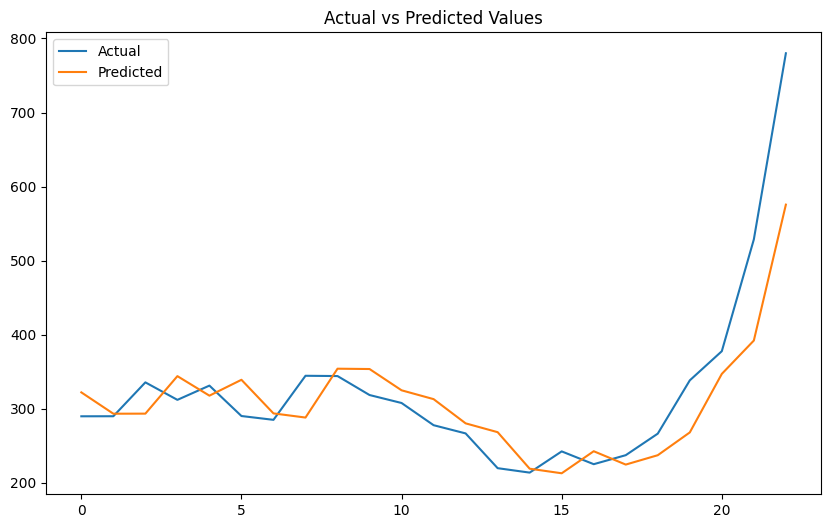

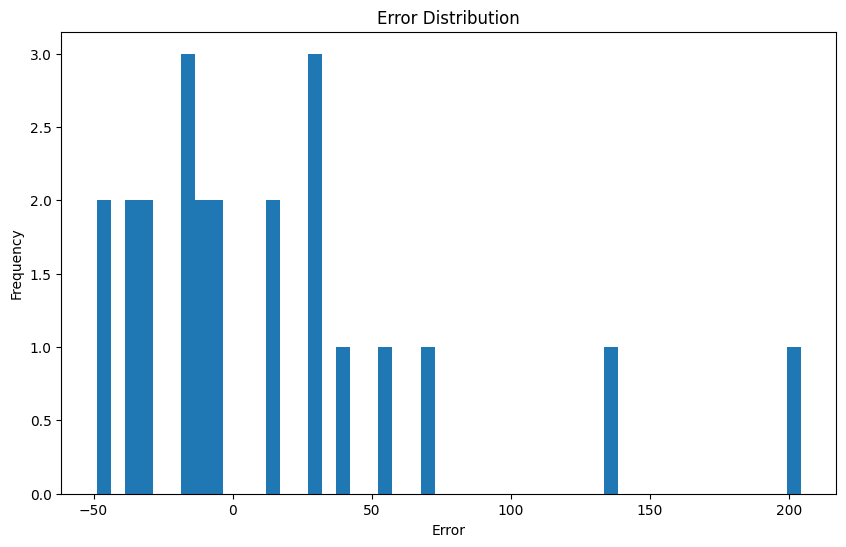

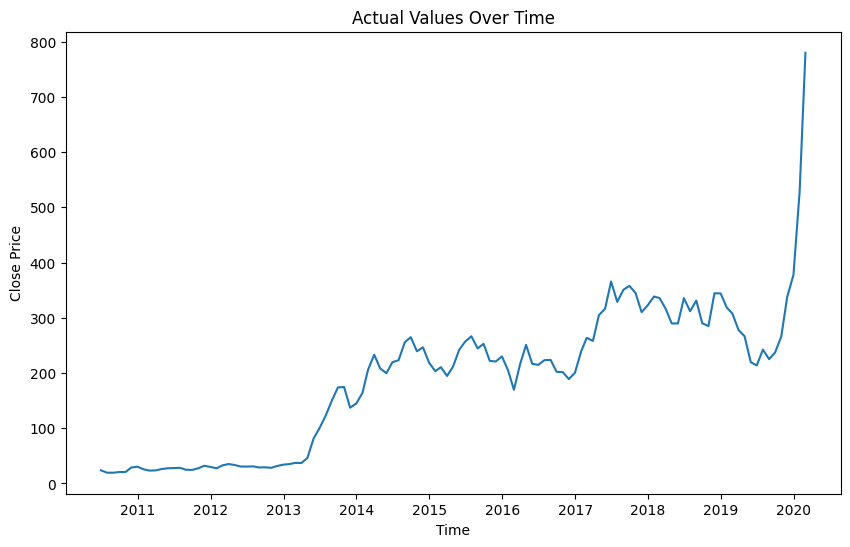

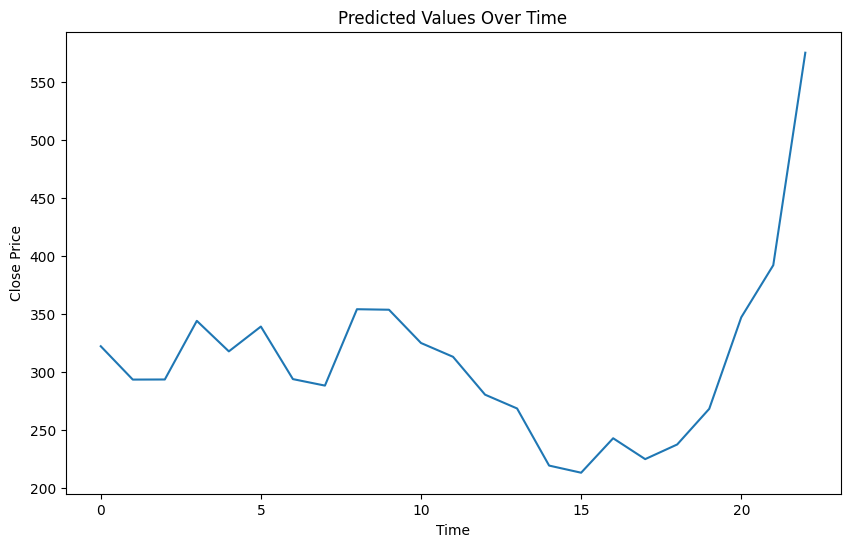

Accuracy:  60.30632589278139


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import plot_model

# Load the dataset
df = pd.read_csv('stockdata.csv')

# Set the date as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample the data to monthly frequency
df_monthly = df.resample('M').mean()

# Create a new dataframe with only the 'Close' column
close_df = df_monthly[['Close']]

# Scale the data using Min-Max Scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_df)

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[0:train_size], scaled_data[train_size:len(scaled_data)]

# Create the training and testing datasets
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step):
        X.append(dataset[i:(i+time_step), 0])
        Y.append(dataset[(i+time_step), 0])
    return np.array(X), np.array(Y)

time_step = 1
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# Reshape the data for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=32)

# Plot the model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Make predictions
predictions = model.predict(X_test)

# Invert the predictions and actual values back to the original scale
predictions = scaler.inverse_transform(predictions)
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Calculate evaluation metrics
mse = mean_squared_error(Y_test, predictions)
mae = mean_absolute_error(Y_test, predictions)
r2 = r2_score(Y_test, predictions)
print("Mean Squared Error (MSE): ", mse)
print("Mean Absolute Error (MAE): ", mae)
print("R-Squared (R2): ", r2)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(Y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()

# Plot the error distribution
plt.figure(figsize=(10, 6))
plt.hist(Y_test - predictions, bins=50)
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

# Plot the actual values over time
plt.figure(figsize=(10, 6))
plt.plot(close_df)
plt.title('Actual Values Over Time')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.show()

# Plot the predicted values over time
plt.figure(figsize=(10, 6))
plt.plot(predictions)
plt.title('Predicted Values Over Time')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.show()

accuracy = np.sqrt(mean_squared_error(Y_test, predictions))
print("Accuracy: ", accuracy)